In [1]:
import os

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import time

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df = df.sample(n=100)
print(df.shape)
df.head()

(100, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
5327157,11,47,429,13090,84.80,25500.0,13.0,110.85,2003.10,642.0,452.0,994.0,760.0,2017,4
3230660,2,44,1068,12679,77.66,18100.0,13.0,98.83,2007.12,583.0,55.0,770.0,605.0,2018,8
2486034,1,160,1003,9602,39.83,10150.0,6.0,59.50,2001.07,504.0,174.0,842.0,564.0,2014,8
4006474,5,104,669,9842,159.30,67348.0,5.0,190.33,2009.02,400.0,81.0,1398.0,1170.0,2013,1
5602008,11,128,995,8637,116.82,63000.0,31.0,156.47,2011.02,546.0,61.0,1783.0,1331.0,2016,6


In [5]:
y = df['price']
del df['price']

In [6]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

# 5 ML models

In [7]:
gboost = GradientBoostingRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
lightgbm = lgb.LGBMRegressor(random_state=0)
lasso = Lasso(alpha=1.0, random_state=0)
svm = svm.SVC(kernel='rbf', C=1, gamma=0.1, random_state=0)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':gboost, 'name': 'GradientBoosting'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':lasso, 'name': 'Lasso'},
          {'model':svm, 'name': 'SVM'}]

In [8]:
def predict_each(models, x, y, sub_x, sub_y):
    for m in models :
        RMSE = []
        
        for m in models:
            start = time.time()
            m['model'].fit(x.values, y)
            predictions = m['model'].predict(sub_x.values) 
            result = sqrt(mean_squared_error(sub_y, predictions))
            end = round((time.time() - start), 4)
            RMSE.append(m['name'])
            RMSE.append(round(result))
            RMSE.append(end)
    return RMSE

In [9]:
y_pred = predict_each(models, x_train, y_train, x_test, y_test)
y_pred

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData

['XGBoost',
 22893,
 0.048,
 'GradientBoosting',
 20960,
 0.021,
 'LightGBM',
 25855,
 0.0102,
 'Lasso',
 11061,
 0.0047,
 'SVM',
 34919,
 0.011]

# Keras

In [10]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [12]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [13]:
start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 42 samples, validate on 28 samples
Epoch 1/100
42/42 [==============================] - 2s 40ms/step - loss: 777575104.0000 - acc: 0.0000e+00 - val_loss: 1075560704.0000 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1075560704.00000, saving model to ./model/01-1075560704.0000.hdf5
Epoch 2/100
42/42 [==============================] - 0s 238us/step - loss: 769831488.0000 - acc: 0.0000e+00 - val_loss: 1067099712.0000 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 1075560704.00000 to 1067099712.00000, saving model to ./model/02-1067099712.0000.hdf5
Epoch 3/100
42/42 [==============================] - 0s 190us/step - loss: 760938944.0000 - acc: 0.0000e+00 - val_loss: 1057624064.0000 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 1067099712.00000 to 1057624064.00000, saving model to ./model/03-1057624064.0000.hdf5
Epoch 4/100
42/42 [==============================] - 0s 190us/step - loss: 7510


Epoch 00029: val_loss improved from 792354240.00000 to 778792640.00000, saving model to ./model/29-778792640.0000.hdf5
Epoch 30/100
42/42 [==============================] - 0s 166us/step - loss: 472270496.0000 - acc: 0.0000e+00 - val_loss: 764965184.0000 - val_acc: 0.0000e+00

Epoch 00030: val_loss improved from 778792640.00000 to 764965184.00000, saving model to ./model/30-764965184.0000.hdf5
Epoch 31/100
42/42 [==============================] - 0s 166us/step - loss: 459912960.0000 - acc: 0.0000e+00 - val_loss: 750868608.0000 - val_acc: 0.0000e+00

Epoch 00031: val_loss improved from 764965184.00000 to 750868608.00000, saving model to ./model/31-750868608.0000.hdf5
Epoch 32/100
42/42 [==============================] - 0s 214us/step - loss: 447457920.0000 - acc: 0.0000e+00 - val_loss: 736534976.0000 - val_acc: 0.0000e+00

Epoch 00032: val_loss improved from 750868608.00000 to 736534976.00000, saving model to ./model/32-736534976.0000.hdf5
Epoch 33/100
42/42 [==========================


Epoch 00059: val_loss improved from 407718112.00000 to 402009760.00000, saving model to ./model/59-402009760.0000.hdf5
Epoch 60/100
42/42 [==============================] - 0s 143us/step - loss: 236722720.0000 - acc: 0.0000e+00 - val_loss: 396789824.0000 - val_acc: 0.0000e+00

Epoch 00060: val_loss improved from 402009760.00000 to 396789824.00000, saving model to ./model/60-396789824.0000.hdf5
Epoch 61/100
42/42 [==============================] - 0s 143us/step - loss: 236257968.0000 - acc: 0.0000e+00 - val_loss: 392012576.0000 - val_acc: 0.0000e+00

Epoch 00061: val_loss improved from 396789824.00000 to 392012576.00000, saving model to ./model/61-392012576.0000.hdf5
Epoch 62/100
42/42 [==============================] - 0s 238us/step - loss: 235720848.0000 - acc: 0.0000e+00 - val_loss: 387636224.0000 - val_acc: 0.0000e+00

Epoch 00062: val_loss improved from 392012576.00000 to 387636224.00000, saving model to ./model/62-387636224.0000.hdf5
Epoch 63/100
42/42 [==========================

Epoch 89/100
42/42 [==============================] - 0s 214us/step - loss: 188531536.0000 - acc: 0.0000e+00 - val_loss: 317167776.0000 - val_acc: 0.0000e+00

Epoch 00089: val_loss improved from 320440896.00000 to 317167776.00000, saving model to ./model/89-317167776.0000.hdf5
Epoch 90/100
42/42 [==============================] - 0s 214us/step - loss: 186988960.0000 - acc: 0.0000e+00 - val_loss: 313820384.0000 - val_acc: 0.0000e+00

Epoch 00090: val_loss improved from 317167776.00000 to 313820384.00000, saving model to ./model/90-313820384.0000.hdf5
Epoch 91/100
42/42 [==============================] - 0s 214us/step - loss: 185460688.0000 - acc: 0.0000e+00 - val_loss: 310419520.0000 - val_acc: 0.0000e+00

Epoch 00091: val_loss improved from 313820384.00000 to 310419520.00000, saving model to ./model/91-310419520.0000.hdf5
Epoch 92/100
42/42 [==============================] - 0s 214us/step - loss: 183946240.0000 - acc: 0.0000e+00 - val_loss: 306895136.0000 - val_acc: 0.0000e+00

Epoch 0

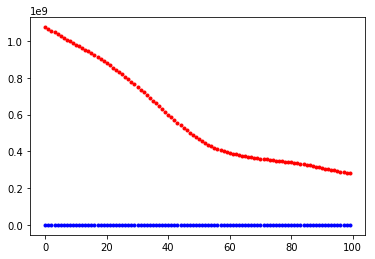

In [14]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [15]:
modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

7.7979


30258.279514929556

In [16]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 20500.000, 예상가격: 31056.633
실제가격: 37000.000, 예상가격: 16250.360
실제가격: 10150.000, 예상가격: 21775.461
실제가격: 16700.000, 예상가격: 25358.910
실제가격: 21300.000, 예상가격: 22851.043
실제가격: 15800.000, 예상가격: 26741.840
실제가격: 30500.000, 예상가격: 26592.945
실제가격: 185000.000, 예상가격: 47546.934
실제가격: 78800.000, 예상가격: 29308.480
실제가격: 25300.000, 예상가격: 29695.994


Train on 42 samples, validate on 28 samples
Epoch 1/10
42/42 [==============================] - 0s 9ms/step - loss: 800246208.0000 - acc: 0.0000e+00 - val_loss: 1104824960.0000 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1104824960.00000, saving model to ./model/01-1104824960.0000.hdf5
Epoch 2/10
42/42 [==============================] - 0s 214us/step - loss: 797861184.0000 - acc: 0.0000e+00 - val_loss: 1104333312.0000 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 1104824960.00000 to 1104333312.00000, saving model to ./model/02-1104333312.0000.hdf5
Epoch 3/10
42/42 [==============================] - 0s 191us/step - loss: 797510208.0000 - acc: 0.0000e+00 - val_loss: 1103914368.0000 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 1104333312.00000 to 1103914368.00000, saving model to ./model/03-1103914368.0000.hdf5
Epoch 4/10
42/42 [==============================] - 0s 190us/step - loss: 797115520.0000 - acc: 0.0000e+00 - val_loss: 1103345792.0

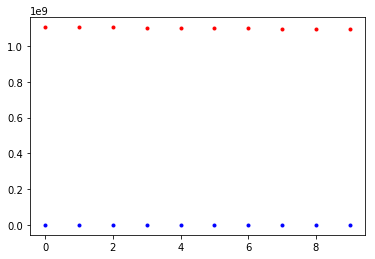

1.763


42833.42964686411

In [18]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=10, batch_size=1000, callbacks=[checkpointer])
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE